In [19]:
%load_ext autoreload
%autoreload 2

main_path = r'.'
data_path = main_path+'/data'
import sys
sys.path.append(main_path)
from BayDS.lib.pipeline import *
from typing import List, Set, Dict, Optional, Any, Tuple, Type, Union
from BayDS.lib.io import *
from BayDS.lib.training import *
import os
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = pd.read_parquet('./FE/BEST1156+Orig.pqt')

In [3]:
cat_fields = ['field12', 'field26', 'field27', 'field29']
for f in cat_fields:
    data[f] = pd.Categorical(data[f])


In [4]:
cat_features = []
for col in data.columns:
    print(col, data[col].dtype.name)
    if data[col].dtype.name in ('category','object'):
        cat_features.append(col)

field16bin_count_groupby_field12 int64
field17_to_std_groupby_(field12+field16bin) float32
field25_to_std_groupby_(field12+field16bin) float32
field16bin_count_groupby_field7 int64
field9_to_stdscore_groupby_(field12+field16bin) float32
price2bin_count_groupby_field16bin int64
field25bin_count_groupby_field16bin int64
field28_to_stdscore_groupby_(field12+field16bin) float32
field17_to_mean_groupby_(field12+field16bin) float32
price1bin_count_groupby_field16bin int64
field25_to_stdscore_groupby_(field12+field16bin) float32
field25_to_std_groupby_(field29+field16bin) float32
field16_to_minmax_groupby_(field12+field6bin) float32
field16bin_count_groupby_field0bin int64
field16bin_count_groupby_lang_country int64
field16bin_count_groupby_field10 int64
field16bin_count_groupby_field6bin int64
field6_to_stdscore_groupby_(field12+field16bin) float32
field15_to_stdscore_groupby_(field12+field16bin) float32
field16bin_count_groupby_field8 int64
field17bin_count_groupby_field16bin int64
field22b

field24_to_minmax_groupby_(field29+price1bin) float32
field22bin_count_groupby_order_till_hour int64
field24_to_minmax_groupby_(field26+price1bin) float32
field13_to_stdscore_groupby_(field26+order_till_hour) float32
field13_to_mean_groupby_(field27+userid) float32
field19_to_minmax_groupby_(field27+field0bin) float32
field24_to_minmax_groupby_(field26+field17bin) float32
field19_to_minmax_groupby_(field26+field22bin) float32
field17bin object
field13_to_minmax_groupby_(field26+order_till_weekday) float32
field6_to_minmax_groupby_(field12+order_till_hour) float32
field15_to_minmax_groupby_(field12+all_children) float32
field29_count_groupby_field10 int64
field13_to_std_groupby_(field26+userid) float32
field15_to_minmax_groupby_(field26+lang_country) float32
field13_to_stdscore_groupby_(field27+userid) float32
field13_to_std_groupby_(field27+order_till_hour) float32
field25_to_minmax_groupby_(field12+order_till_hour) float32
all_children_count_groupby_order_till_hour int64
field3 int64


In [5]:
cat_features

['field12',
 'price2bin',
 'price1bin',
 'field22bin',
 'field25bin',
 'order_till_month',
 'field6bin',
 'field13bin',
 'field0bin',
 'field17bin',
 'field26',
 'field29',
 'field27',
 'field16bin',
 'all_children',
 'userid']

## Encoding

In [6]:
LE=LabelEncoderPopularity()

for newcat in cat_features:
    print(newcat)
    LE.fit(data[newcat])
    d = LE.transform(data[newcat])
    data[newcat] = d.astype(np.int32)

field12
price2bin
price1bin
field22bin
field25bin
order_till_month
field6bin
field13bin
field0bin
field17bin
field26
field29
field27
field16bin
all_children
userid


In [7]:
for col in data.columns:
   
    if data[col].dtype.name in ('category','object'):
            print(col, data[col].dtype.name)

In [8]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1']

In [9]:
train_columns = [c for c in data.columns if c not in exclude_features_from_training]

In [10]:
data.userid

orderid
1000000    180515
1000001     78919
1000002     77975
1000003     42930
1000004    160110
            ...  
455006     338623
455007     354408
455008     121899
455009     343516
455010      78446
Name: userid, Length: 651067, dtype: int32

## Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
for column in tqdm(train_columns):
#     print(column)
    col = data[column].astype(np.float32)
    filtered = col[~col.isin([np.inf, -np.inf])].dropna()
    vmax = filtered.max()
    vmin = filtered.min()
    vmean = filtered.mean()
    col = col.replace({
        np.inf:vmax,
        -np.inf:vmin
       }).fillna(vmean)
    if vmax > 100 and vmin >= 0:
        col = np.log1p(col)
    
    scaler = StandardScaler()
    col.values[...] = scaler.fit_transform(col.values.reshape(-1,1)).flatten()
    
    data[column] = col


  4%|███                                                                             | 45/1171 [00:15<04:39,  4.03it/s]

KeyboardInterrupt: 

In [ ]:
data.to_parquet('./FE/BEST1156+Orig_ENCODED_SCALED.pqt')

In [2]:
data = pd.read_parquet('./FE/BEST1156+Orig_ENCODED_SCALED.pqt')

In [3]:
for col in data.columns:
    if data[col].dtype.name not in ('float32', 'float64'):
        print (col,data[col].dtype.name)
        pass
    if data[col].dtype.name == 'float64':
        print(col)

goal24
indicator_goal24 int64
indicator_goal25 int64
indicator_goal22 int64
indicator_goal23 int64
indicator_goal21 int64
goal1
goal21
goal22
goal23
goal25


In [4]:
data = data.fillna(0)

In [ ]:
# train_idx = data[data['goal1']>=0].index
# test_idx = data[data['goal1']<0].index
# X = data.loc[train_idx,train_columns]
# test = data.loc[test_idx,train_columns]
# y = data[data['goal1']>=0]['goal1'].astype(np.uint8)

# merg = pd.concat([X,test])

In [ ]:
# from category_encoders.cat_boost import CatBoostEncoder
# encoder = CatBoostEncoder(verbose=1,cols=cat_features)
# encoder.fit(X,y)


In [ ]:
# merg = encoder.transform(merg)

In [ ]:
# best_features = pd.read_pickle('./data/best_features_1070.pkl')

# cats = []
# for col in best_features.columns:
#     if best_features[col].dtype.name in ['object', 'category']:
#         cats.append(col)

# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# for col in [x for x in cats if x not in ['userid']]:
#     best_features[col] = le.fit_transform(best_features[col])

# best_features = reduce_mem_usage_sd(best_features, verbose=True, obj_to_cat=True)

# best_features = best_features.replace([np.inf, -np.inf], np.nan)

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# best_features = scaler.fit_transform(best_features)

# df = pd.read_pickle('./data/best_features_1070.pkl')

# best_features = pd.DataFrame(best_features, index=df.index, columns=df.columns)

# del df
# gc.collect()

# best_features.to_pickle('./temp/best_features_scaled.pkl')

In [ ]:
data.userid

## Training


In [5]:
exclude_features_from_training = ['indicator_goal21', 'indicator_goal22', 'indicator_goal23',
       'indicator_goal24', 'indicator_goal25', 'goal21', 'goal22', 'goal23',
       'goal24', 'goal25', 'goal1', 'order_till_hour', 'order_till_weekday', 'order_till_month', 'lang_country']

train_idx = data[data['goal1']>=0].index
test_idx = data[data['goal1']<0].index
X = data.loc[train_idx]
y = data[data['goal1']>=0]['goal1']
test=data.loc[test_idx]
train_features = [f for f in data.columns if f not in exclude_features_from_training]

del data
gc.collect()

1207

In [31]:
from keras.layers import Concatenate, Input, Dense, Embedding, Flatten, Dropout, BatchNormalization, SpatialDropout1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as k
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

def NNModel_maker():
#     k.clear_session()
    
    numerical_inputs = Input(shape=[len(train_features)], name = 'all')
    numerical_logits = Dropout(.3)(numerical_inputs)
  
    x = numerical_logits
    x = Dense(600, activation = 'relu')(x)
    x = Dropout(.3)(x)
    x = Dense(300, activation = 'relu')(x)
    x = Dropout(.3)(x)
#     x = Dense(200, activation = 'relu')(x)
#     x = Dropout(.3)(x)
    x = Dense(100, activation = 'relu')(x)
    x = Dropout(.3)(x)
    out = Dense(1, activation = 'sigmoid')(x)    

    model = Model(inputs= [numerical_inputs],outputs=out)
    loss = "binary_crossentropy"
    model.compile(optimizer=Adam(lr = 0.0003), loss = loss)
    return model

In [32]:
from sklearn.model_selection import GroupKFold, KFold
n_fold = 5
folds = GroupKFold(n_splits=n_fold)

params = {
    'batch_size': 8000,
    'epochs': 20,
    'verbose': True,
         }
train_options = {
    "model_type":'keras',
    "params": params,
    "eval_metric": 'auc',
    'averaging': 'rank',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': 5
   
}

In [33]:
gc.collect()
result_dict_keras = train_model_classification_vb(model=NNModel_maker, 
                                             X=X,
                                             X_test=test,
                                             columns=train_features,
                                             y=y.astype(int), params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             averaging=train_options['averaging'],
                                             groups=X['userid'])

Fold 1 started at Mon Jan  6 23:03:27 2020
Train on 156844 samples, validate on 39212 samples
Epoch 1/20
156844/156844 [==============================] - 8s 51us/step - loss: 0.2428 - val_loss: 0.1313
Epoch 2/20
156844/156844 [==============================] - 6s 41us/step - loss: 0.1319 - val_loss: 0.1283
Epoch 3/20
156844/156844 [==============================] - 7s 42us/step - loss: 0.1191 - val_loss: 0.1137
Epoch 4/20
156844/156844 [==============================] - 7s 42us/step - loss: 0.1157 - val_loss: 0.1171
Epoch 5/20
156844/156844 [==============================] - 6s 41us/step - loss: 0.1136 - val_loss: 0.1161
Epoch 6/20
156844/156844 [==============================] - 6s 41us/step - loss: 0.1132 - val_loss: 0.1166
Epoch 7/20
156844/156844 [==============================] - 6s 41us/step - loss: 0.1111 - val_loss: 0.1172
Epoch 8/20
156844/156844 [==============================] - 6s 41us/step - loss: 0.1105 - val_loss: 0.1179
Epoch 9/20
156844/156844 [========================

156845/156845 [==============================] - 7s 42us/step - loss: 0.1097 - val_loss: 0.1092
Epoch 14/20
156845/156845 [==============================] - 7s 42us/step - loss: 0.1090 - val_loss: 0.1105
Epoch 15/20
156845/156845 [==============================] - 7s 42us/step - loss: 0.1083 - val_loss: 0.1107
Epoch 16/20
156845/156845 [==============================] - 7s 42us/step - loss: 0.1080 - val_loss: 0.1099
Epoch 17/20
156845/156845 [==============================] - 7s 42us/step - loss: 0.1072 - val_loss: 0.1110
Epoch 18/20
156845/156845 [==============================] - 7s 42us/step - loss: 0.1071 - val_loss: 0.1078
Epoch 19/20
156845/156845 [==============================] - 7s 42us/step - loss: 0.1062 - val_loss: 0.1098
Epoch 20/20
156845/156845 [==============================] - 7s 42us/step - loss: 0.1063 - val_loss: 0.1094
Fold 3. auc: 0.6838.
Fold 5 started at Mon Jan  6 23:14:18 2020
Train on 156845 samples, validate on 39211 samples
Epoch 1/20
156845/156845 [=======

In [ ]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict_keras['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv(f'./temp/submission-{t}.csv')
import pickle
pickle.dump(result_dict_keras,open(f'./temp/keras-{t}.pkl','wb'))

In [14]:
result_dict_keras

{'oof': array([[0.02243519],
        [0.08084103],
        [0.01509893],
        ...,
        [0.02037685],
        [0.05321216],
        [0.09573482]]), 'prediction': array([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]), 'scores': [0.6717354737497159,
  0.6779589100634047,
  0.6898522165865029,
  0.6880739347836727,
  0.6719004703353659]}

In [32]:
result_dict

{'oof': array([[0.01115465],
        [0.04667869],
        [0.02266118],
        ...,
        [0.00765774],
        [0.0197279 ],
        [0.02982333]]), 'prediction': array([[ 39825. ],
        [ 48613.4],
        [422502.8],
        ...,
        [161948.6],
        [419498.2],
        [200601. ]]), 'scores': [0.6877827253559686,
  0.7308985349999676,
  0.699807765802827,
  0.6853947137493746,
  0.6908908686113436], 'feature_importance':                                               feature          importance  \
 0                    field16bin_count_groupby_field12  19.399999999999999   
 1         field17_to_std_groupby_(field12+field16bin)  12.800000000000001   
 2         field25_to_std_groupby_(field12+field16bin)   4.600000000000000   
 3                     field16bin_count_groupby_field7  15.199999999999999   
 4     field9_to_stdscore_groupby_(field12+field16bin)   7.400000000000000   
 ...                                               ...                 ...   
 1060       

In [22]:
from sklearn.model_selection import GroupKFold, KFold

NFOLDS = 5
folds = GroupKFold(n_splits=NFOLDS)
params = {
          'objective': 'binary',
          "metric": 'auc',
          "verbosity": -1,
    'learning_rate': 0.01,
    'max_depth':20,
    'num_leaves':50
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 100,
        'n_estimators': 500,
        'averaging': 'rank',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Sat Jan  4 20:16:16 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.7951	training's auc: 0.795105	valid_1's auc: 0.672875	valid_1's auc: 0.672865
[200]	training's auc: 0.857433	training's auc: 0.857433	valid_1's auc: 0.682769	valid_1's auc: 0.682769
[300]	training's auc: 0.899833	training's auc: 0.899833	valid_1's auc: 0.685933	valid_1's auc: 0.685933
[400]	training's auc: 0.927588	training's auc: 0.927588	valid_1's auc: 0.685714	valid_1's auc: 0.685714
[500]	training's auc: 0.948018	training's auc: 0.948018	valid_1's auc: 0.687783	valid_1's auc: 0.687783
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.948018	training's auc: 0.948018	valid_1's auc: 0.687783	valid_1's auc: 0.687783
Fold 2 started at Sat Jan  4 20:21:41 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.790239	training's auc: 0.790238	valid_1's auc: 0.720925	valid_1's auc: 0.720946
[200]	training

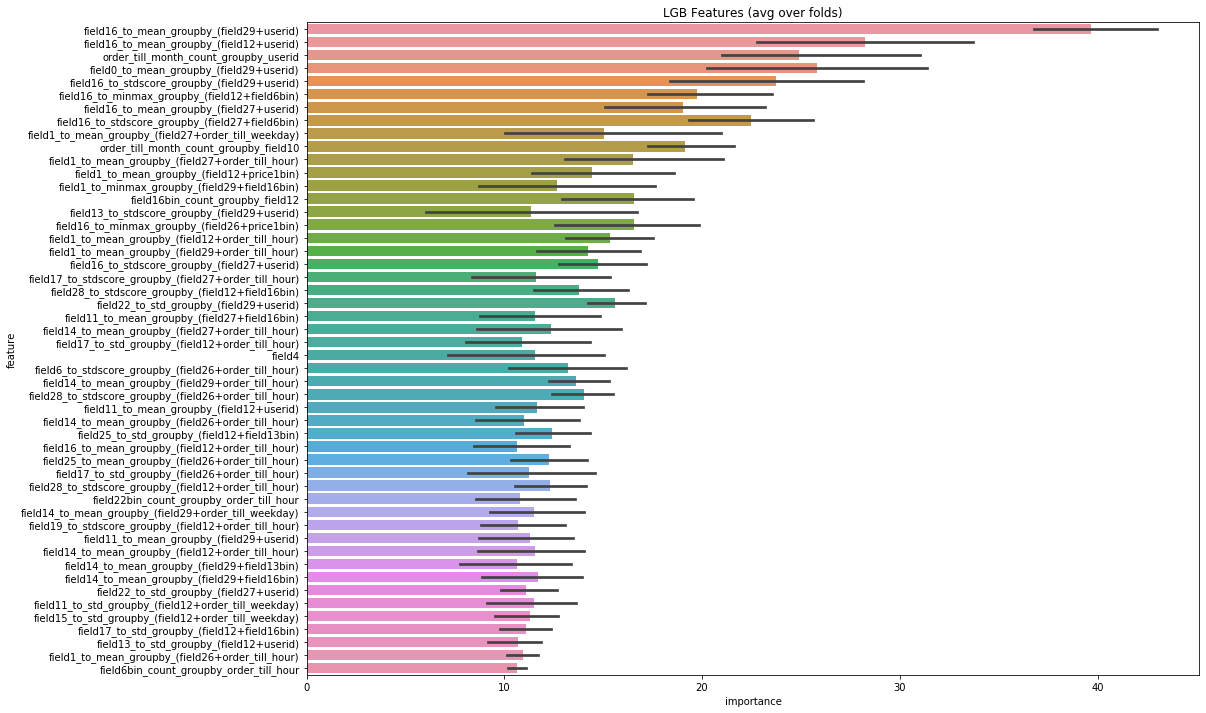

In [23]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)

In [25]:
import datetime
t = datetime.datetime.now().strftime("%m-%d-%H-%M")
test['proba'] = result_dict['prediction']
sub = pd.read_csv('data/onetwotrip_challenge_sub1.csv')
sub['proba'] = test['proba'] / test['proba'].max()
sub.reset_index(drop=True).set_index('orderid').to_csv('./temp/submission-{t}.csv')

Fold 1 started at Sat Jan  4 14:29:13 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.797201	training's auc: 0.797202	valid_1's auc: 0.670295	valid_1's auc: 0.670299
[200]	training's auc: 0.859572	training's auc: 0.859572	valid_1's auc: 0.682299	valid_1's auc: 0.682299
[300]	training's auc: 0.901514	training's auc: 0.901514	valid_1's auc: 0.68417	valid_1's auc: 0.68417
[400]	training's auc: 0.929149	training's auc: 0.929149	valid_1's auc: 0.684377	valid_1's auc: 0.684377
Early stopping, best iteration is:
[367]	training's auc: 0.92024	training's auc: 0.92024	valid_1's auc: 0.684642	valid_1's auc: 0.684642
Fold 2 started at Sat Jan  4 14:34:05 2020
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.792754	training's auc: 0.792753	valid_1's auc: 0.719666	valid_1's auc: 0.71967
[200]	training's auc: 0.854274	training's auc: 0.854273	valid_1's auc: 0.726832	valid_1's auc: 0.726833
[300]	training's auc: 0.900796

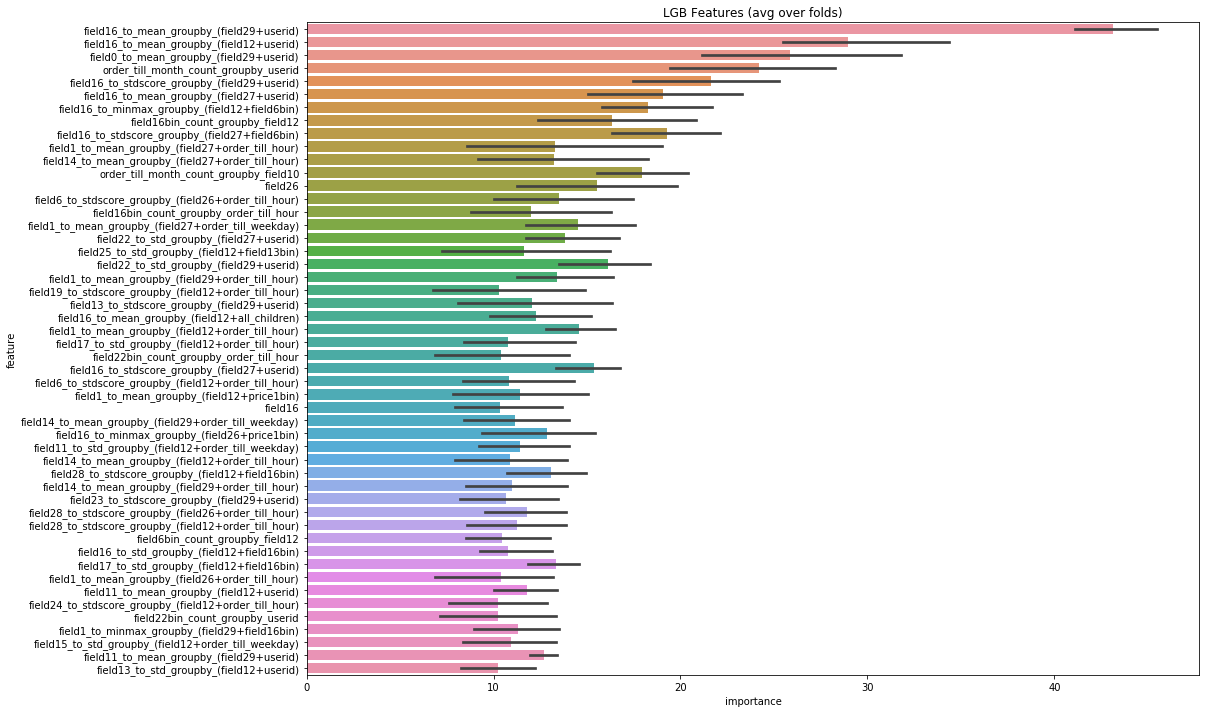

In [15]:
result_dict = train_model_classification_vb( X=X, 
                                             X_test=test, 
                                             columns=train_features,
                                             y=y, 
                                             params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             groups=X['userid'],
                                             n_jobs=-1)